# Data science tips
## 시계열 데이터 병합하기

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.09.02 </div> 
<div style="text-align: right"> Last update: 2020.09.02</div> 

- 참고자료 1 : https://www.kite.com/blog/python/pandas-merge-join-concat/
- 참고자료 2 : https://towardsdatascience.com/practical-uses-of-merge-join-and-concat-8f011bbac241

실행결과를 보려면 다음 링크를 참고하세요.[[링크]](https://nbviewer.jupyter.org/gist/sguys99/af42bbf4d76e04a2228966cb9ce6f42c)

<img src = 'https://raw.githubusercontent.com/sguys99/Datascience-tips/master/src/4.1.jpg' width = 700>

pandas는 다수의 데이터프레임을 병합하는데 유용한 라이브러리를 몇가지 제공한다.(concat, merge, join)  
pd.concat은 동일한 컬럼명을 가지는 다수의 데이터를 합치는데 유용하다.- 수직병합(vertical merging)에 유용  
merge와 join은 기준이 되는 키 값을 통해 데이터프레임의 컬럼을 확장할 때 유용하다. - 수평병합(horizontal merging)에 유용  

## 1. 데이터 가져오기

라이브러리 import
- 주식 일별 데이터를 가져오기 위해 `FinanceDataReader` 라이브러리를 사용한다.[[참고자료]](https://github.com/FinanceData/FinanceDataReader/blob/master/tutorial/FinanceDataReader%20Tutorial%20-%20%EC%97%AC%EB%9F%AC%20%EC%A2%85%EB%AA%A9%EC%9D%98%20%EA%B0%80%EA%B2%A9%EC%9D%84%20%ED%95%9C%EB%B2%88%EC%97%90.ipynb)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

import FinanceDataReader as fdr

철강 3사 posco(005490), 현대제철(004020), KG동부제철(016380) 데이터를 가져온다.

In [2]:
stock1 = fdr.DataReader('005490', '2020-1-01', '2020-8-27')
stock2 = fdr.DataReader('004020', '2020-1-01', '2020-8-27')
stock3 = fdr.DataReader('016380', '2020-1-01', '2020-8-27')

날짜컬럼('Date')과 종목명('Company'), 종목코드('Symbol') 추가하기

In [3]:
stock1['Date'] = stock1.index
stock2['Date'] = stock2.index
stock3['Date'] = stock3.index

In [4]:
stock1 = stock1.reset_index(drop = True)
stock2 = stock2.reset_index(drop = True)
stock3 = stock3.reset_index(drop = True)

In [5]:
stock1['Company'] = 'posco'
stock2['Company'] = '현대제철'
stock3['Company'] = '동부제철'

In [6]:
stock1['Symbol'] = '005490'
stock2['Symbol'] = '004020'
stock3['Symbol'] = '016380'

In [7]:
stock1.head(3)

,Open,High,Low,Close,Volume,Change,Date,Company,Symbol
0,236000,240000,234500,236000,213578,-0.002114,2020-01-02,posco,005490
1,237500,242000,236500,237000,273831,0.004237,2020-01-03,posco,005490
2,234000,234500,230000,231000,217886,-0.025316,2020-01-06,posco,005490


In [8]:
stock2.head(3)

,Open,High,Low,Close,Volume,Change,Date,Company,Symbol
0,31600,31650,31050,31200,367943,-0.007949,2020-01-02,현대제철,004020
1,31250,31450,30750,30800,482613,-0.012821,2020-01-03,현대제철,004020
2,30500,30600,29600,29650,639706,-0.037338,2020-01-06,현대제철,004020


In [9]:
stock3.head()

,Open,High,Low,Close,Volume,Change,Date,Company,Symbol
0,7910,7940,7500,7730,58776,-0.008974,2020-01-02,동부제철,016380
1,7730,7820,7520,7700,61580,-0.003881,2020-01-03,동부제철,016380
2,7610,7710,7570,7700,19674,0.000000,2020-01-06,동부제철,016380
3,7630,7740,7630,7680,16573,-0.002597,2020-01-07,동부제철,016380
4,7680,7690,7400,7410,30792,-0.035156,2020-01-08,동부제철,016380


데이터 크기확인

In [10]:
print(stock1.shape)
print(stock2.shape)
print(stock3.shape)

(164, 9)
(164, 9)
(164, 9)


## 2. Univerate time series merging  
- 각 주식의 종가('Close')만 추출하여 series 데이터를 만든다.  
- 이 데이터들을 병합하는 방법에 대하여 설명한다. 데이터 분석에 용이한 형태여야 한다.

동일한 컬럼 정보를 가지는 univerate 데이터셋을 분석 할때는 컬럼 단위로 병합, 분석하는 것이 편하다.  
예를들어 철강업종들의 종가('Close')를 비교분석 하고 싶다면, 각 종목의 종가별로 수평병합 하면된다. 

먼저 각 종목의 종가만 추출하여 series 데이터를 만든다.

In [11]:
series1 = stock1.set_index('Date')['Close']
series2 = stock2.set_index('Date')['Close']
series3 = stock3.set_index('Date')['Close']

In [12]:
series1.head()

Date
2020-01-02    236000
2020-01-03    237000
2020-01-06    231000
2020-01-07    232000
2020-01-08    228000
Name: Close, dtype: int64

### 2.1 pd.concat()으로 합치기  
- concat()는 기준 컬럼이나 인덱스 없이 데이터를 병합한다.

In [13]:
Stocks_closed = pd.concat([series1, series2, series3], axis = 1 )
# axis = 0 : vertical 병합, axis = 1 : horizontal 병합

In [14]:
Stocks_closed.columns = ['posco', '현대제철', '동부제철']

In [15]:
Stocks_closed.head()

,posco,현대제철,동부제철
Date,,,
2020-01-02,236000,31200,7730
2020-01-03,237000,30800,7700
2020-01-06,231000,29650,7700
2020-01-07,232000,29500,7680
2020-01-08,228000,28200,7410


- 위 경우 각 데이터의 인덱스(날짜)가 모두 같았다.  
- 날짜가 다른 데이터를 concat()으로 병합하면 어떻게 될까?

길이는 같지만 날짜 구간이 다른 데이터를 만들어본다.

In [16]:
series1 = stock1.set_index('Date').loc['2020-01-02':'2020-01-15':, 'Close']
series2 = stock2.set_index('Date').loc['2020-01-04':'2020-01-17':, 'Close']

In [17]:
series1

Date
2020-01-02    236000
2020-01-03    237000
2020-01-06    231000
2020-01-07    232000
2020-01-08    228000
2020-01-09    234000
2020-01-10    237500
2020-01-13    238500
2020-01-14    242000
2020-01-15    242000
Name: Close, dtype: int64

In [18]:
series2

Date
2020-01-06    29650
2020-01-07    29500
2020-01-08    28200
2020-01-09    28250
2020-01-10    28800
2020-01-13    29350
2020-01-14    30500
2020-01-15    30800
2020-01-16    30050
2020-01-17    30050
Name: Close, dtype: int64

pd.concat()으로 병합한다.

In [19]:
Stocks_closed = pd.concat([series1, series2], axis = 1 )

In [20]:
Stocks_closed

,Close,Close
Date,,
2020-01-02,236000.0,NaN
2020-01-03,237000.0,NaN
2020-01-06,231000.0,29650.0
2020-01-07,232000.0,29500.0
2020-01-08,228000.0,28200.0
2020-01-09,234000.0,28250.0
2020-01-10,237500.0,28800.0
2020-01-13,238500.0,29350.0
2020-01-14,242000.0,30500.0


- 운좋게도 성공했다.
- 그런데 concat으로 데이터프레임을 수평병합 하는 것은 위험하다.  
- 앞에서는 Date index를 기준으로 자동 병합이 되었다.

다음과 같은 경우는 각 데이터의 기준일이 다른 것을 인식하지 못할 것이다.

In [21]:
series1 = pd.Series(stock1.set_index('Date').loc['2020-01-02':'2020-01-15':, 'Close'].values)
series2 = pd.Series(stock2.set_index('Date').loc['2020-01-04':'2020-01-17':, 'Close'].values)

In [22]:
series1

0    236000
1    237000
2    231000
3    232000
4    228000
5    234000
6    237500
7    238500
8    242000
9    242000
dtype: int64

In [23]:
Stocks_closed = pd.concat([series1, series2], axis = 1 )

In [24]:
Stocks_closed

,0,1
0,236000,29650
1,237000,29500
2,231000,28200
3,232000,28250
4,228000,28800
5,234000,29350
6,237500,30500
7,238500,30800
8,242000,30050
9,242000,30050


- 따라서 univerate 데이터를 수평병합 할때에는 키값(on) 옵션이 있는  pd.merge를 활용하는 것이 안전하다. 

### 2.2 pd.merge()로 데이터 합치기

In [25]:
series1 = stock1.set_index('Date')['Close']
series2 = stock2.set_index('Date')['Close']
series3 = stock3.set_index('Date')['Close']

In [26]:
Stocks_closed = pd.merge(series1, series2, on = 'Date', how = 'left').merge(series3, on = 'Date', how ='left')

In [27]:
Stocks_closed.columns = ['posco', '현대제철', '동부제철']

In [28]:
Stocks_closed.head()

,posco,현대제철,동부제철
Date,,,
2020-01-02,236000,31200,7730
2020-01-03,237000,30800,7700
2020-01-06,231000,29650,7700
2020-01-07,232000,29500,7680
2020-01-08,228000,28200,7410


## 3. Multivariate time series merging  
- Open, High, Low, Close 컬럼 등을 포함하는 다변수 데이터를 병합한다.  
- 다음의 두가지 예가 있을 것이다.  
    - 여러 기업의 주가정보 병합  
    - 한 기업의 주가정보와 기업정보 병합
- 데이터분석에 용이한 형태여야 한다.

### 3.1 주가정보 병합 : pd.concat()을 사용한 수직(vertical) 병합

먼저 pd.concat()을 사용하여 각 종목을 수직으로 병합한다.

In [29]:
stocks = pd.concat([stock1, stock2, stock3], axis = 0, ignore_index=True)

In [30]:
stocks

,Open,High,Low,Close,Volume,Change,Date,Company,Symbol
0,236000,240000,234500,236000,213578,-0.002114,2020-01-02,posco,005490
1,237500,242000,236500,237000,273831,0.004237,2020-01-03,posco,005490
2,234000,234500,230000,231000,217886,-0.025316,2020-01-06,posco,005490
3,231500,234500,231000,232000,138750,0.004329,2020-01-07,posco,005490
4,229000,229500,226500,228000,340244,-0.017241,2020-01-08,posco,005490
...,...,...,...,...,...,...,...,...,...
487,12250,12650,12150,12200,65142,-0.035573,2020-08-21,동부제철,016380
488,12400,12450,11800,12450,60127,0.020492,2020-08-24,동부제철,016380
489,12350,12550,12200,12350,69823,-0.008032,2020-08-25,동부제철,016380
490,12250,12400,11900,12100,67527,-0.020243,2020-08-26,동부제철,016380


`Date` 컬럼을 기준으로 정렬한다.

In [31]:
stocks = stocks.sort_values(by = 'Date', ascending=True, ignore_index=True)

In [32]:
stocks.head(10)

,Open,High,Low,Close,Volume,Change,Date,Company,Symbol
0,236000,240000,234500,236000,213578,-0.002114,2020-01-02,posco,005490
1,31600,31650,31050,31200,367943,-0.007949,2020-01-02,현대제철,004020
2,7910,7940,7500,7730,58776,-0.008974,2020-01-02,동부제철,016380
3,237500,242000,236500,237000,273831,0.004237,2020-01-03,posco,005490
4,31250,31450,30750,30800,482613,-0.012821,2020-01-03,현대제철,004020
5,7730,7820,7520,7700,61580,-0.003881,2020-01-03,동부제철,016380
6,234000,234500,230000,231000,217886,-0.025316,2020-01-06,posco,005490
7,30500,30600,29600,29650,639706,-0.037338,2020-01-06,현대제철,004020
8,7610,7710,7570,7700,19674,0.000000,2020-01-06,동부제철,016380
9,29750,29900,29350,29500,450825,-0.005059,2020-01-07,현대제철,004020


`Date` 컬럼을 인덱스로 설정한다.

In [33]:
stocks = stocks.set_index('Date')

In [34]:
stocks.head(10)

,Open,High,Low,Close,Volume,Change,Company,Symbol
Date,,,,,,,,
2020-01-02,236000,240000,234500,236000,213578,-0.002114,posco,005490
2020-01-02,31600,31650,31050,31200,367943,-0.007949,현대제철,004020
2020-01-02,7910,7940,7500,7730,58776,-0.008974,동부제철,016380
2020-01-03,237500,242000,236500,237000,273831,0.004237,posco,005490
2020-01-03,31250,31450,30750,30800,482613,-0.012821,현대제철,004020
2020-01-03,7730,7820,7520,7700,61580,-0.003881,동부제철,016380
2020-01-06,234000,234500,230000,231000,217886,-0.025316,posco,005490
2020-01-06,30500,30600,29600,29650,639706,-0.037338,현대제철,004020
2020-01-06,7610,7710,7570,7700,19674,0.000000,동부제철,016380


- 위와 같은 형태로 데이터를 병합하면, 데이터분석이나 예측모델을 구성할 때 용이하다.

예를들어 posco주식의 종가(Close)만 시각화하고 싶다면 다음과 같이 인덱싱을 하면된다.

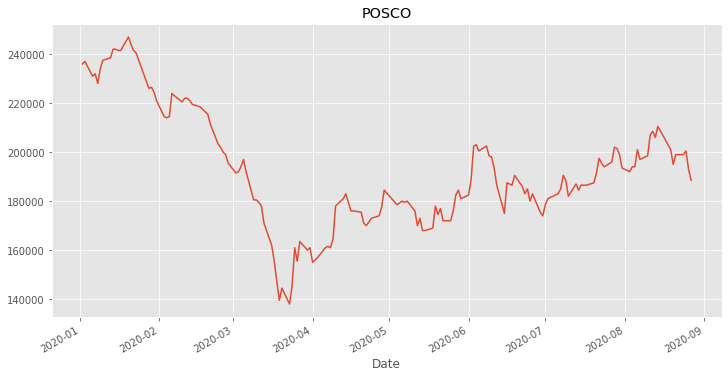

In [35]:
stocks.loc[stocks['Company']=='posco', 'Close'].plot(figsize = (12, 6))
plt.title('POSCO')
plt.show()

### 3.2 주가정보와 기업정보 병합 : pd.merge(), pd.join()을 사용한 수평(horizontal) 병합

우선 `FinanceDataReader` 라이브러리로 상장기업의 정보 데이터를 받아온다.  
- KRX : KRX 종목전체 , KOSPI : KOSPI 종목 , KOSDAQ : KOSDAQ 종목

In [36]:
krx = fdr.StockListing('KRX')

In [37]:
krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,특수 목적용 기계 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"윤규선, 이현우(각자대표)",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


- 위 기업정보를 주가정보와 수평병합 할 것이다.

merge와 join은 데이터프레임을 수평으로 합치기 위한 데이터이다.  
두 라이브러리는 유사하게 동작한다. join을 사용하면 하위에서 merge가 동작한다. 

join이든 merge이든 데이터를 병합할 때 how 옵션을 잘 사용해야 한다.  
how의 주요 옵션인 `left`, `Right`, `Inner`, `Outer`의 특징은 다음과 같다.  
- Left : 첫번째 DF는 유지한 상태에서, 두번째 DF의 컬럼 정보를 병합한다.  
- Right : Left의 반대  
- Inner : 상호 겹치는 부분만 유지한다. 따라서 NaN 값이 없다.  
- Outer : 모든 열을 남긴다.  

위 네가지 옵션은 SQL의 join 과도 같다.  
**주의 :** merge의 how 디펄트는 inner이고, join의 how 디펄트는 left이다.

#### pd.merge()를 사용한 병합

posco 주가정보와 기업정보 데이터를 병합해본다. 병합할 때 종목코드(Symbol)를 기준으로 한다.

In [38]:
stock1_merged = stock1.merge(krx[['Symbol', 'Sector', 'Region']], on = 'Symbol', how = 'left')

In [39]:
stock1_merged = stock1_merged.set_index('Date')

In [40]:
stock1_merged.head()

,Open,High,Low,Close,Volume,Change,Company,Symbol,Sector,Region
Date,,,,,,,,,,
2020-01-02,236000,240000,234500,236000,213578,-0.002114,posco,005490,1차 철강 제조업,경상북도
2020-01-03,237500,242000,236500,237000,273831,0.004237,posco,005490,1차 철강 제조업,경상북도
2020-01-06,234000,234500,230000,231000,217886,-0.025316,posco,005490,1차 철강 제조업,경상북도
2020-01-07,231500,234500,231000,232000,138750,0.004329,posco,005490,1차 철강 제조업,경상북도
2020-01-08,229000,229500,226500,228000,340244,-0.017241,posco,005490,1차 철강 제조업,경상북도


#### pd.join()을 사용한 병합

merge를 사용한 방법과 유사하다. 단 키 값을 인덱스로 설정해야 한다.

In [41]:
stock1_merged = stock1.merge(krx[['Symbol', 'Sector', 'Region']].set_index('Symbol'), on = 'Symbol', how = 'left')

In [42]:
stock1_merged = stock1_merged.set_index('Date')

In [43]:
stock1_merged.head()

,Open,High,Low,Close,Volume,Change,Company,Symbol,Sector,Region
Date,,,,,,,,,,
2020-01-02,236000,240000,234500,236000,213578,-0.002114,posco,005490,1차 철강 제조업,경상북도
2020-01-03,237500,242000,236500,237000,273831,0.004237,posco,005490,1차 철강 제조업,경상북도
2020-01-06,234000,234500,230000,231000,217886,-0.025316,posco,005490,1차 철강 제조업,경상북도
2020-01-07,231500,234500,231000,232000,138750,0.004329,posco,005490,1차 철강 제조업,경상북도
2020-01-08,229000,229500,226500,228000,340244,-0.017241,posco,005490,1차 철강 제조업,경상북도


## 4. Case study : 풍력 관련주 데이터셋 만들기

기업정보 데이터 불러오기

In [44]:
krx = fdr.StockListing('KRX')

In [45]:
krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,특수 목적용 기계 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"윤규선, 이현우(각자대표)",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [46]:
krx = krx.dropna(how = 'any')

기업정보에서 `풍력` 문구를 포함하는 산업군을 인덱싱한다.

In [47]:
krx[krx['Industry'].str.contains('풍력')]

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
1230,297090,KOSDAQ,씨에스베어링,일반 목적용 기계 제조업,"풍력용 선회베어링, 산업용 선회베어링",2019-11-21,12월,"조만제, 방성훈",http://www.cs-bearing.co.kr,경상남도
1231,112610,KOSPI,씨에스윈드,"구조용 금속제품, 탱크 및 증기발생기 제조업",풍력발전타워 제조,2014-11-27,12월,"김성권, 김승범",http://www.cswind.com,충청남도
1641,018000,KOSDAQ,유니슨,일반 목적용 기계 제조업,"풍력발전기, 풍력타워",1996-01-10,12월,허화도,http://www.unison.co.kr,경상남도
2234,119500,KOSDAQ,포메탈,기타 금속 가공제품 제조업,"자동차,풍력,방위산업,산업기계,농기계등의 단조부품",2010-09-17,12월,오호석,http://www.formetal.co.kr,충청남도


해당기업의 이름('Name')과 종목코드('Symbol')만 추출한다.

In [48]:
code = krx[krx['Industry'].str.contains('풍력')][['Name', 'Symbol']]

위 정보를 바탕으로 주가정보를 받는다.

In [49]:
stocks = pd.DataFrame()
for name, symbol in zip(code['Name'], code['Symbol']):
    stock = fdr.DataReader(symbol, '2020-1-01', '2020-8-27')
    stock['Date'] = stock.index
    stock = stock.reset_index(drop = True)
    stock['Symbol'] = symbol
    stock['Company'] = name
    stocks = pd.concat([stocks, stock], axis = 0, ignore_index=True) 

날짜를 기준으로 데이터를 정렬한다.

In [50]:
stocks = stocks.sort_values(by = 'Date', ascending=True, ignore_index=True)

In [51]:
stocks.head(20)

,Open,High,Low,Close,Volume,Change,Date,Symbol,Company
0,8550,8840,8550,8650,165273,0.018846,2020-01-02,297090,씨에스베어링
1,37800,37800,37000,37350,42689,-0.017105,2020-01-02,112610,씨에스윈드
2,2925,2935,2900,2920,81614,-0.003413,2020-01-02,119500,포메탈
3,1005,1020,1000,1015,516471,0.009950,2020-01-02,018000,유니슨
4,37450,38750,37450,38100,47462,0.020080,2020-01-03,112610,씨에스윈드
5,8680,8760,8420,8570,177648,-0.009249,2020-01-03,297090,씨에스베어링
6,1020,1020,1000,1010,383921,-0.004926,2020-01-03,018000,유니슨
7,2920,2960,2900,2915,121102,-0.001712,2020-01-03,119500,포메탈
8,38000,39050,37450,38500,80918,0.010499,2020-01-06,112610,씨에스윈드
9,8490,8570,8260,8300,88846,-0.031505,2020-01-06,297090,씨에스베어링


주가정보와 종목정보를 수평병합한다.

In [52]:
stocks_merged = stocks.merge(krx[['Symbol', 'Sector', 'Region']], on = 'Symbol', how = 'left')

인덱스를 날짜로 설정한다.

In [53]:
stocks = stocks_merged.set_index('Date')

In [54]:
stocks.head(10)

,Open,High,Low,Close,Volume,Change,Symbol,Company,Sector,Region
Date,,,,,,,,,,
2020-01-02,8550,8840,8550,8650,165273,0.018846,297090,씨에스베어링,일반 목적용 기계 제조업,경상남도
2020-01-02,37800,37800,37000,37350,42689,-0.017105,112610,씨에스윈드,"구조용 금속제품, 탱크 및 증기발생기 제조업",충청남도
2020-01-02,2925,2935,2900,2920,81614,-0.003413,119500,포메탈,기타 금속 가공제품 제조업,충청남도
2020-01-02,1005,1020,1000,1015,516471,0.009950,018000,유니슨,일반 목적용 기계 제조업,경상남도
2020-01-03,37450,38750,37450,38100,47462,0.020080,112610,씨에스윈드,"구조용 금속제품, 탱크 및 증기발생기 제조업",충청남도
2020-01-03,8680,8760,8420,8570,177648,-0.009249,297090,씨에스베어링,일반 목적용 기계 제조업,경상남도
2020-01-03,1020,1020,1000,1010,383921,-0.004926,018000,유니슨,일반 목적용 기계 제조업,경상남도
2020-01-03,2920,2960,2900,2915,121102,-0.001712,119500,포메탈,기타 금속 가공제품 제조업,충청남도
2020-01-06,38000,39050,37450,38500,80918,0.010499,112610,씨에스윈드,"구조용 금속제품, 탱크 및 증기발생기 제조업",충청남도
